# Books versus eBooks : The customer's choice

You need to have the metadata.json and the two 5-core files reviews_Books_5.json and reviews_Kindle_Store_5.json at the same level as the notebook.

For the questions asked for Milestone 2, please refer to the README file, where you will see a part dedicated to milestone 2. In this Notebook, we don't answer specifically to these questions, but we speak at each step what we technically made and failed.

## Data retrieval

In [2]:
import pandas as pd
import re
import numpy as np
import requests
import time
from bs4 import BeautifulSoup
from ast import literal_eval
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import qgrid
%matplotlib inline

#### Warning :
There are several booleans in this cell. They are useful to indicate if we need to perform some key data filtering and transformation in the whole notebook. The first one is set to True as it creates a file that is bigger than 300Mo, so that we can't put it in github. You will have to compute it if you run the notebook (it takes some time). The other files are on github, so all other booleans are set to False.

In [3]:
metadata_path = 'metadata.json'
books_metadata_path = 'books_metadata_with_bracket.csv'
ebooks_metadata_title_path = 'ebooks_metadata_title.csv'
ebooks_asin = 'ebooks_asin.csv'
books_5core_path = 'reviews_Books_5.json'
kindle_5core_path = 'reviews_Kindle_Store_5.json'
amazon_ebooks = 'ebooks_title_from_amazon_complete.csv'
amazon_aws_ebooks = 'ebooks_metadata_amazon.csv'
amazon_aws_ebooks_undefined = 'ebooks_metadata_amazon_undefined.csv'
amazon_aws_ebooks_log = 'ebooks_metadata_amazon_log.csv'
asindb_ebooks = 'ebooks_title_from_asindb.csv'

amazon_aws_books = 'books_metadata_amazon_all.csv'
amazon_aws_books_undefined = 'books_metadata_amazon_undefined_p.csv'
amazon_aws_books_log = 'books_metadata_amazon_log_p.csv'

matched_books_path = 'matched_books_by_authors.csv'
matched_ebooks_path = 'matched_ebooks_by_authors.csv'
matched_books_path_nolax = 'matched_books_by_authors_nolax.csv'
matched_ebooks_path_nolax = 'matched_ebooks_by_authors_nolax.csv'
matched_books_short = 'matched_books.csv'
matched_ebooks_short = 'matched_ebooks.csv'
weighted_scores_books_path = 'weighted_scores_books.csv'
weighted_scores_ebooks_path = 'weighted_scores_ebooks.csv'


WRITE_BOOKS_METADATA = False
WRITE_EBOOKS_METADATA_TITLE = False
WRITE_EBOOK_ASIN = False
AMAZON_GET_TITLE = False
ASINDB_GET_TITLE = False
WRITE_FIND_MATCHED = False
WRITE_WEIGHTED_SCORE = True
WRITE_SCORES = False
WRITE_FLAT = False

As for our project, we need to obtain ebook data and book data, we chose the Amazon dataset. On this <a href='http://jmcauley.ucsd.edu/data/amazon/'>link</a>, we have downloaded the Books and Kindle Store 5-core files. However, those files contain reviews, so that we have no information about the article title or price.
For that reason, we had to use the metadata file, acting as an intermediate table (relationship).

We obtained the metadata.json file from the cluster, as it was not available in the website.
We accessed the cluster using ssh@iccluster060.iccluster.epfl.ch, then using 
```shell
hadoop fs -get /datasets/productGraph/metadata.json /buffer
```
to move the dataset to a folder we could connect to with SCP to download it on our computer.


It's a json file, that is not readable using the pandas read_json method. We had to use the Code part from <a href='http://jmcauley.ucsd.edu/data/amazon/'>here</a> to read it. We can see a way to read the file (a limited portion of it) below :

In [207]:
def read_json(path, limit = 2): 
    g = open(path, 'r') 
    df = {}
    for i, l in enumerate(g): 
        if i < limit:
            df[i] = eval(l)
        else:
            break
    return pd.DataFrame.from_dict(df, orient='index')

def read_csv(path, limit = 2): 
    return pd.read_csv(path, nrows=limit)
            
read_json(metadata_path)

,imUrl,salesRank,asin,title,categories,related,price,description
0,http://ecx.images-amazon.com/images/I/51MKP0T4...,{'Books': 6334800},0001048791,"The Crucible: Performed by Stuart Pankin, Jero...",[[Books]],NaN,NaN,NaN
1,http://g-ecx.images-amazon.com/images/G/01/x-s...,{'Movies & TV': 376041},0000143561,"Everyday Italian (with Giada de Laurentiis), V...","[[Movies & TV, Movies]]","{'buy_after_viewing': ['B0036FO6SI', 'B000KL8O...",12.99,"3Pack DVD set - Italian Classics, Parties and ..."


However, this metadata.json file takes more than 10 Go, for 9430088 entries (obtained by doing a wc -l metadata.json), so it does not fit in memory. Thus, as we will do a lot of tests later, we wanted to create a subfile containing only the Books metadata (we don't need video games metadata for example), with a subset of columns. We also want to write it in the csv format, to manipulate it in an easier way later.

We use the regex "\[\'books" in an ignore case mode, to obtain only entries that have a category tag beginning with [Books. In fact, if we want to use the regex 'book', some entries like 0078800242 or B00000078S are not books at all, even if there is Books in the title or the category tag. The '[' is useful here to avoir this behavior.

In [208]:
def read_book_metadata(path, regex): 
    g = open(path, 'r') 
    for l in g: 
        book = regex.search(l)
        if book:
            yield eval(l) 
            
def write_df_books_metadata(from_, to, regex, columns_to_keep): 
    i = 0 
    df = {} 
    for d in read_book_metadata(from_, regex): 
        df[i] = d 
        i += 1 
        if i % 10000 == 0: # Here, we choose to write everything every 10'000 book entries, and clear the dataframe to free memory.
            pd.DataFrame.from_dict(df, orient='index')[columns_to_keep].to_csv(to, header=False,mode='a')
            df = {}

COLUMNS_TO_KEEP = ['asin', 'salesRank', 'categories', 'title', 'price']
regex = re.compile('\[\'books', re.IGNORECASE)

if WRITE_BOOKS_METADATA:
    pd.DataFrame(columns=[COLUMNS_TO_KEEP]).to_csv(books_metadata_path)
    write_df_books_metadata(metadata_path, books_metadata_path, regex, COLUMNS_TO_KEEP)

And if we read what we just wrote :

In [209]:
read_csv(books_metadata_path)

,Unnamed: 0,asin,salesRank,categories,title,price
0,0,1048791,{'Books': 6334800},[['Books']],"The Crucible: Performed by Stuart Pankin, Jero...",NaN
1,1,1048775,{'Books': 13243226},[['Books']],Measure for Measure: Complete &amp; Unabridged,NaN


We also wanted to obtain the ebooks titles, price etc..
For the category filter, we have to use the same trick as for the Books one : "\[\'Kindle". Please note that some book metadatas above are in fact kindle store metadatas, because the category can contain both. However, it's not a big deal if we want to do the merge later, because as we will see, pretty much no ebook has a title in the given metadata.

However, for the metadatas for ebooks, there was a problem at that step :

In [210]:
def read_ebook_metadata(path, regex): 
    g = open(path, 'r') 
    for l in g: 
        ebook = regex.search(l)
        if ebook:
            yield eval(l) 
def obtain_df_ebooks_metadata(from_, to, regex): 
    i = 0 
    df = {} 
    count = 0
    for d in read_ebook_metadata(from_, regex): 
        count += 1
        if(d.get('title')):
            df[i] = {'asin': d.get('asin'), 'title': d.get('title')}
            i += 1 
    pd.DataFrame.from_dict(df, orient='index').to_csv(to)
    print('Total ebooks in metadatas:', count)


regex = re.compile('\[\'Kindle', re.IGNORECASE)

if WRITE_EBOOKS_METADATA_TITLE:
    obtain_df_ebooks_metadata(metadata_path, ebooks_metadata_title_path, regex)

We see right below that 44 entries out of 434702 have a title. Of course, it's not good at all, since we want to merge books and ebooks using the title field.

In [211]:
read_csv(ebooks_metadata_title_path, None).shape[0]

44

Thus, we need to obtain the title field from another source. The first idea was to retrieve this information from Amazon directly, as we wanted to do for the user location. For that, we need to have a list of the ebooks asin (Amazon Standard Identification Numbers). We obtain it from the Kindle Store 5-core file.

In [212]:
def read_ebook_5core(path, regex): 
    g = open(path, 'r') 
    for l in g: 
        yield eval(l) 
def write_ebook_asin(from_, to): 
    i = 0 
    df = {} 
    for d in read_ebook_5core(from_, regex): 
        df[i] = d 
        i += 1 
        if i % 10000 == 0:
            if i % 100000 == 0:
                print(i) #to show the progression
            pd.DataFrame.from_dict(df, orient='index')[['asin']].to_csv(to, header=False,mode='a')
            df = {}
    pd.DataFrame.from_dict(df, orient='index')[['asin']].to_csv(to, header=False,mode='a')
    df = {}

if WRITE_EBOOK_ASIN:
    pd.DataFrame(columns=[['asin']]).to_csv(ebooks_asin)
    write_ebook_asin(kindle_5core_path, ebooks_asin)

As we were using the Kindle Store 5-core file, there are asin duplicates. We thus make it unique when we read.

In [17]:
ebooks_asin_unique = pd.read_csv('ebooks_asin.csv',usecols=[1]).asin.unique()
ebooks_asin_unique

array(['B000F83SZQ', 'B000FA64PA', 'B000FA64PK', ..., 'B00M029T4O',
       'B00M0RE7CS', 'B00M13FNSS'], dtype=object)

In [215]:
ebooks_metadata = read_csv(asindb_ebooks, None)
ebooks_metadata.head()

,Unnamed: 0,asin,title
0,B000FA64PA,B000FA64PA,Saboteur: Star Wars Legends (Darth Maul) (Shor...
1,B000FA64PK,B000FA64PK,Recovery: Star Wars Legends (The New Jedi Orde...
2,B000FA64QO,B000FA64QO,Ylesia: Star Wars Legends (The New Jedi Order)...
3,B000FBFMVG,B000FBFMVG,A Forest Apart: Star Wars Legends (Short Story...
4,B000FC1BN8,B000FC1BN8,Fool's Bargain: Star Wars Legends (Novella) (S...


In [216]:
read_csv(asindb_ebooks, None).shape[0] # number of titles retrieved

2741

This solution is of course not the best one : the asindb website does not contain everything. We have managed to retrieve 2741 titles over 4000 asins by using this technique, but we have no problem with the Amazon bot detection (and possible ban). We can see which entries were not retrieved by printing the notdefined dataframe.

Of course, tu retrieve the 2741 entries, we set the LIMIT constant in the code to be 4000.

We thus continue our analysis by using it.

Now, as we have the title information for books and ebooks, let's merge them. We read the book metadata information in books_metadata and we have the ebook metadata information with title in ebooks_metadata.

In [217]:
books_metadata = pd.read_csv(books_metadata_path)
books_metadata.head()

,Unnamed: 0,asin,salesRank,categories,title,price
0,0,0001048791,{'Books': 6334800},[['Books']],"The Crucible: Performed by Stuart Pankin, Jero...",NaN
1,1,0001048775,{'Books': 13243226},[['Books']],Measure for Measure: Complete &amp; Unabridged,NaN
2,2,0001048236,{'Books': 8973864},[['Books']],The Sherlock Holmes Audio Collection,9.26
3,3,0000401048,{'Books': 6448843},[['Books']],The rogue of publishers' row;: Confessions of ...,NaN
4,4,0001019880,{'Books': 9589258},[['Books']],Classic Soul Winner's New Testament Bible,5.39


We merge them on title, and we see that we only get 1297 entries. It's not bad, but we can for sure have a better result. As we can remark, there is a lot of time the title The Space Between. We will discuss later about it.

In [218]:
#We merge, and get the head. Everything after is here just to have a nicer representation of the first elements
books_metadata.merge(ebooks_metadata, left_on='title', right_on='title').head().iloc[:,[1,7,2,3,4,5]].rename(columns={'asin_x':'asin_books', 'asin_y':'asin_ebooks'})

,asin_books,asin_ebooks,salesRank,categories,title,price
0,0002008505,B002DYJ7DM,{'Books': 5587764},[['Books']],The Space Between,4.74
1,0615891411,B002DYJ7DM,{'Books': 4145053},[['Books']],The Space Between,2.99
2,1579660584,B002DYJ7DM,{'Books': 2486827},[['Books']],The Space Between,20.08
3,1588515508,B002DYJ7DM,{'Books': 5985767},[['Books']],The Space Between,NaN
4,1595143394,B002DYJ7DM,{'Books': 141638},[['Books']],The Space Between,7.13


In [219]:
books_metadata.merge(ebooks_metadata, left_on='title', right_on='title').shape[0]

1297

As we were saying, 1297 is not a big number, and we can do better. We have done the most basic possible thing to do : we have put the title for books and ebooks in lower form (minuscule).

In [220]:
books_metadata['title'] = books_metadata.title.str.lower()
books_metadata.head()

,Unnamed: 0,asin,salesRank,categories,title,price
0,0,0001048791,{'Books': 6334800},[['Books']],"the crucible: performed by stuart pankin, jero...",NaN
1,1,0001048775,{'Books': 13243226},[['Books']],measure for measure: complete &amp; unabridged,NaN
2,2,0001048236,{'Books': 8973864},[['Books']],the sherlock holmes audio collection,9.26
3,3,0000401048,{'Books': 6448843},[['Books']],the rogue of publishers' row;: confessions of ...,NaN
4,4,0001019880,{'Books': 9589258},[['Books']],classic soul winner's new testament bible,5.39


In [221]:
ebooks_metadata['title'] = ebooks_metadata.title.str.lower()
ebooks_metadata.head()

,Unnamed: 0,asin,title
0,B000FA64PA,B000FA64PA,saboteur: star wars legends (darth maul) (shor...
1,B000FA64PK,B000FA64PK,recovery: star wars legends (the new jedi orde...
2,B000FA64QO,B000FA64QO,ylesia: star wars legends (the new jedi order)...
3,B000FBFMVG,B000FBFMVG,a forest apart: star wars legends (short story...
4,B000FC1BN8,B000FC1BN8,fool's bargain: star wars legends (novella) (s...


In [222]:
merged_metadatas = books_metadata.merge(ebooks_metadata, left_on='title', right_on='title')
merged_metadatas = merged_metadatas[['asin_x', 'asin_y', 'title', 'price', 'categories', 'salesRank']]
merged_metadatas = merged_metadatas.rename(columns={'asin_x': 'asin_book', 'asin_y': 'asin_ebook'})

In [223]:
merged_metadatas.head()

,asin_book,asin_ebook,title,price,categories,salesRank
0,0002008505,B002DYJ7DM,the space between,4.74,[['Books']],{'Books': 5587764}
1,0615891411,B002DYJ7DM,the space between,2.99,[['Books']],{'Books': 4145053}
2,1579660584,B002DYJ7DM,the space between,20.08,[['Books']],{'Books': 2486827}
3,1588515508,B002DYJ7DM,the space between,NaN,[['Books']],{'Books': 5985767}
4,1595143394,B002DYJ7DM,the space between,7.13,[['Books']],{'Books': 141638}


As we see, we have a bigger number of entries. We could have tried to increase this number, however as we will see later, we already have some problems with this 'strict' way of doing.

In [22]:
merged_metadatas.shape[0]

1506

So we have merged the two dataframes into one, and it seems that we can do some analysis on it. We have 1506 entries, so it's good for a first analysis in milestone 2 to do so.
But, as said before, there are title duplicates. It corresponds to books (there is only one duplicate entry for ebooks, for the article 'Second Chances') that have the same title.

In [23]:
merged_metadatas.head(7)

,asin_book,asin_ebook,title,price,categories,salesRank
0,0002008505,B002DYJ7DM,the space between,4.74,[['Books']],{'Books': 5587764}
1,0615891411,B002DYJ7DM,the space between,2.99,[['Books']],{'Books': 4145053}
2,1579660584,B002DYJ7DM,the space between,20.08,[['Books']],{'Books': 2486827}
3,1588515508,B002DYJ7DM,the space between,NaN,[['Books']],{'Books': 5985767}
4,1595143394,B002DYJ7DM,the space between,7.13,[['Books']],{'Books': 141638}
5,1601540817,B002DYJ7DM,the space between,10.99,[['Books']],{'Books': 11114107}
6,1625530226,B002DYJ7DM,the space between,6.99,[['Books']],{'Books': 2678708}


In [24]:
ebooks_metadata.title.describe()

count               2741
unique              2739
top       second chances
freq                   2
Name: title, dtype: object

We thus thought that we could consider only pairs that have a unique title in the whole dataframe. In that way, we only have articles that have a unique name, at least in the period in which the dataset has been created, so that we could only have exactly the same content for the book and the ebook. 

We thus drop all elements that have a title that exists more than one time in the dataframe.

It's naive, as we don't have all books and ebooks of Amazon, even for the period given, but we wanted to try.

In [25]:
merged_metadatas = merged_metadatas.drop_duplicates('title',keep=False)
merged_metadatas.head(7)

,asin_book,asin_ebook,title,price,categories,salesRank
39,0007269854,B003ZUY19I,the ice princess,7.59,[['Books']],{'Books': 2527081}
95,0060517689,B0036ZAHDG,in the mood,2.99,[['Books']],{'Books': 2663548}
121,0060595620,B00480P58K,the sweetest taboo,8.70,[['Books']],{'Books': 2956119}
173,0060813032,B0049H8X86,"dragons from the sea (the strongbow saga, book 2)",3.60,[['Books']],{'Books': 1269204}
200,0061084220,B004QS98KU,raven's bride,7.69,[['Books']],{'Books': 2911109}
460,0140249249,B003XVYGXK,iced,NaN,[['Books']],{'Books': 1225702}
461,0140259678,B003C1R5CA,a timely death,NaN,[['Books']],{'Books': 3077680}


We now only have 148 elements in the merged collection. We reming the reader about the fact that we tried to obtain 4000 ebooks titles, we got only 2741. By merging, we got 1506 entries, and when we drop all elements that have duplicates, we only have 148 elements.

In [26]:
merged_metadatas.shape[0]

148

After some manual analysis, we have unfortunately seen that for most entries, even if there is only one tuple (asin_book, asin_ebook), the two are not on the same content. We have an example for the first entry (the ice princess) : 'https://www.amazon.com/Princess-Patrik-Hedstrom-Erica-Falck/dp/0007269854' and 'https://www.amazon.com/Ice-Princess-Elizabeth-Hoyt-ebook/dp/B003ZUY19I' have the same title but are written by two different people, and have different content.

There are some tuples that match : for the article 'dragons from the sea (the strongbow saga, book 2)', we have the same content.

It's hard for us to quantify the number of such articles that do not match. We have done some by hand, and we have seen that a lot was not matching at all. A way to have good matches automatically could be to obtain the authors. We think that for the same author, it's rare to have two book with the same name. If we forget a minute about problems like the number of authors which is different for the ebook and the book even if it's the same, or different naming conventions (A fictive example : J. F. Brown or J. Brown), we would need the author information for each book and ebook of the tuples that we have merged.

The website we were <a href='http://asindb.com/'>using</a> does not provide this information. We then need to obtain it from somewhere else. 

We have tried to look at the library genesis, using this <a href='http://garbage.world/posts/libgen/'>tutorial</a>. However, there are only two ways to get back information about a book : using a special id (Libgen id), or by date. Furthermore, the asin field exists, but after some tests for which none of the articles had asin, it's hard to say if it's a good option. Thus, we have thought it's not the best solution for us.

We have also been told to look at the Gutenberg project. It could have been a good idea if we could search by asin in the metadatas, that are available. However, it seems that the asin data is not available, so we won't use it neither.

In [27]:
ebooks_asin_unique

array(['B000F83SZQ', 'B000FA64PA', 'B000FA64PK', ..., 'B00M029T4O',
       'B00M0RE7CS', 'B00M13FNSS'], dtype=object)

In [7]:
import bottlenose

AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_ASSOCIATE_TAG = pickle.load(open('amazon_access_epfl_new.txt', "rb"))

In [8]:
(AWS_ACCESS_KEY_ID,AWS_SECRET_ACCESS_KEY,AWS_ASSOCIATE_TAG) = pd.read_csv('amazon_keys.csv', header=None, usecols=[1]).values.flatten()

In [9]:
import random
import time
from urllib.error import HTTPError

def error_handler(err):
    ex = err['exception']
    if isinstance(ex, HTTPError) and ex.code == 503:
        time.sleep(random.expovariate(0.1))
        return True

In [10]:
amazon = bottlenose.Amazon(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_ASSOCIATE_TAG, ErrorHandler=error_handler)

In [11]:
books_asin_unique = pd.read_csv('books_asin.csv',usecols=[1]).asin.unique()

In [14]:
len(books_asin_unique)

367982

In [12]:
BEGIN = 367950
END = 400000
SIMULTANEOUS_REQUESTS = 10
STEP = 50
override = False

There are entries that are still not available through the Advertising API : B000FC26RI

Also newspaper don't comply to this contract of authors : The Wall Street Journal (B000FDJ0FS)

In [13]:
dataframe_books = pd.DataFrame(columns=['title', 'authors', 'manufacturer'])
dataframe_undefined = pd.DataFrame(columns=['title', 'authors', 'manufacturer'])
log = pd.Series()

if(override):
    dataframe_books.to_csv(amazon_aws_books)
    dataframe_undefined.to_csv(amazon_aws_books_undefined)
    log.to_csv(amazon_aws_books_log)

books_simultaneous_list = []

for i, book_asin in enumerate(books_asin_unique[BEGIN:END]):
    books_simultaneous_list += [book_asin]
    
    if i>0 and i%SIMULTANEOUS_REQUESTS == 0:
        keys = ','.join(books_simultaneous_list)
        books_simultaneous_list = []
        if i%STEP==0 and i > 0:
            print(i+BEGIN)
            dataframe_books[['title', 'authors', 'manufacturer']].to_csv(amazon_aws_books, header=False,mode='a')
            dataframe_books = pd.DataFrame(columns=['title', 'authors', 'manufacturer'])

            dataframe_undefined[['title', 'authors', 'manufacturer']].to_csv(amazon_aws_books_undefined, header=False,mode='a')
            dataframe_undefined = pd.DataFrame(columns=['title', 'authors', 'manufacturer'])

            log.to_csv(amazon_aws_books_log, header=False,mode='a')
            log = pd.Series()

        response = amazon.ItemLookup(ItemId=keys)
        soup = BeautifulSoup(response, 'html.parser')
        
        items = soup.find_all('item')
        for item in items:
            all_important_defined = True
            authors_retrieved = []
            
            asins = item.find_all('asin')
            if(len(asins) != 0):
                asin_retrieved = asins[0].text.strip()
            else:
                asin_retrieved = ''
                all_important_defined = False

            titles = item.find_all('title')
            if(len(titles) != 0):
                title_retrieved = titles[0].text.strip()
            else:
                title_retrieved = ''
                all_important_defined = False

            manufacturers = item.find_all('manufacturer')
            if(len(manufacturers) != 0):
                manufacturer_retrieved = manufacturers[0].text.strip()
            else:
                manufacturer_retrieved = ''

            authors = item.find_all('author')
            if(len(authors) != 0):
                for author in authors:
                    authors_retrieved += [author.text.strip()]
            else:
                authors_retrieved = []
                all_important_defined = False

            new_entry = pd.DataFrame({'title':title_retrieved,'authors':", ".join(authors_retrieved), 'manufacturer':manufacturer_retrieved},index=[asin_retrieved])
            if(all_important_defined):
                dataframe_books = dataframe_books.append(new_entry)
            else:
                dataframe_undefined = dataframe_undefined.append(new_entry)
                log = log.append(pd.Series(item.prettify()))

dataframe_books[['title', 'authors', 'manufacturer']].to_csv(amazon_aws_books, header=False,mode='a')
dataframe_undefined[['title', 'authors', 'manufacturer']].to_csv(amazon_aws_books_undefined, header=False,mode='a')
log.to_csv(amazon_aws_books_log, header=False,mode='a')

-- --
## Review analysis

Even if we have some problems that will need to be fixed for the milestone 3, we have continued in the analysis. Of course we had to test with wrong data, but we will ensure that in the future, we will make it work on correct data (one with same author and title for books and ebooks). The code is here to show that we have worked on other steps of the pipeline.

In [100]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

//anaconda/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Here you will need to uncomment this and download vader_lexicon as described in the README.

In [4]:
#nltk.download_shell()

In [101]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext(appName="Pi")
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [102]:
from pyspark.sql.functions import udf, array, col
import pyspark.sql.functions as F
import pyspark.sql.types as T

Next we are going to fetch the reviews of the books for which we have the ebooks.

As the file for the reviews of the books is quite big, we are going the read it into chunks.

In [31]:
def find_matched(list_asins, in_path, out_path):
    pd.DataFrame(columns=[['asin','overall', 'summary', 'reviewerID', 'helpful','reviewText', 'reviewerName', 'reviewTime']]).to_csv(out_path)
    
    for chunk in pd.read_json(in_path, lines=True, chunksize=50000):
        # look if some asins of the chunk match the ones in the given list
        filtered = chunk[chunk['asin'].isin(list_asins)].dropna(how='all')
        
        if len(filtered) > 0:
            # write the data if any
            filtered[['asin','overall', 'summary', 'reviewerID', 'helpful','reviewText', 'reviewerName', 'reviewTime']].to_csv(out_path,header=False, mode='a')


### Working with the new dataset

In [4]:
ebooks_metadata = pd.read_csv('ebooks_metadata_amazon.csv')
books_metadata = pd.read_csv('books_metadata_amazon_lax.csv')

#books_metadata = pd.read_csv('books_metadata_amazon_all.csv')

# remove the duplicated entries
ebooks = ebooks_metadata.copy().set_index('title')
print(len(ebooks))
ebooks = ebooks[~ebooks.index.duplicated()]

books = books_metadata.copy().set_index('title')
print(len(books))
books = books[~books.index.duplicated()]


49020
317480


#### Duplicate the books with mutiple authors
create a new entry with each of the authors who colaborated

In [134]:
ebooks.head()

,Unnamed: 0,authors,manufacturer,rank,price,currency,reldate,page,language
title,,,,,,,,,
Boba Fett: A Practical Man: Star Wars Legends (Short Story) (Star Wars - Legends),B000JMKNQ0,Karen Traviss,Del Rey,250846.0,NaN,NaN,2006-08-08,104.0,English
The Mysterious Island,B000JMLBHU,Jules Verne,Public Domain Books,NaN,NaN,NaN,1998-04-01,516.0,English
"Knots, Splices and Rope Work A Practical Treatise",B000JMLG4S,A.(Alpheus) Hyatt Verrill,Public Domain Books,NaN,NaN,NaN,2004-09-21,47.0,English
The English Orphans,B000JMLHYC,Mary Jane Holmes,Public Domain Books,NaN,NaN,NaN,2004-10-26,290.0,English
Indian Fairy Tales,B000JQUSBQ,Public Domain Books,Public Domain Books,NaN,NaN,NaN,2004-12-01,184.0,English


In [12]:
def treat_and_get_mean_var_rank(path_dataframe):
    amazon_ebooks_metadata = pd.read_csv(path_dataframe)#.rename(columns={'Unnamed: 0':'asin'}).drop_duplicates(subset='asin')
    
    authors_unmerged = amazon_ebooks_metadata.authors.str.split(', ').apply(pd.Series).unstack().dropna()
    
    ind = amazon_ebooks_metadata.authors.str.split(', ').apply(pd.Series)
    ind[ind.isna()] = -1
    ind[ind != -1] = pd.np.nan
    ind['index']=ind.index
    cols = list(ind.columns.values)
    cols = cols[-1:] + cols[:-1]
    ind = ind[cols]
    ind = ind.fillna(method='pad', axis=1)
    cols = cols[1:]

    ind = ind[cols]
    ind[ind == -1] = pd.np.nan
    ind = ind.unstack().dropna()
    authors_unmerged_with_ind = pd.DataFrame(authors_unmerged.values, index=ind.values.astype(np.int64))
    
    ebooks_with_unmerged_authors = amazon_ebooks_metadata.copy().loc[authors_unmerged_with_ind.index.values]
    ebooks_with_unmerged_authors['authors'] = authors_unmerged_with_ind.values
    
    return ebooks_with_unmerged_authors

In [13]:
if WRITE_FLAT:
    books_nolax = treat_and_get_mean_var_rank('books_metadata_amazon_all.csv')
    ebooks_nolax = treat_and_get_mean_var_rank('ebooks_metadata_amazon.csv')
    
    books_nolax.to_csv('books_flat_authors.csv')
    ebooks_nolax.to_csv('ebooks_flat_authors.csv')

In [53]:
books_nolax = pd.read_csv('books_flat_authors.csv')
ebooks_nolax = pd.read_csv('ebooks_flat_authors.csv')

Here we merge the dataset of the paperback books with the dataset of the kindle on the authors to obtain the authors who have books on both supports.

In [55]:
ebooks_nolax.rename(columns={'Unnamed: 0.1':'asin'}, inplace=True)
ebooks_nolax.head()

,Unnamed: 0,asin,title,authors,manufacturer,rank,price,currency,reldate,page,language
0,0,B000JMKNQ0,Boba Fett: A Practical Man: Star Wars Legends ...,Karen Traviss,Del Rey,250846.0,NaN,NaN,2006-08-08,104.0,English
1,1,B000JMLBHU,The Mysterious Island,Jules Verne,Public Domain Books,NaN,NaN,NaN,1998-04-01,516.0,English
2,2,B000JMLG4S,"Knots, Splices and Rope Work A Practical Treatise",A.(Alpheus) Hyatt Verrill,Public Domain Books,NaN,NaN,NaN,2004-09-21,47.0,English
3,3,B000JMLHYC,The English Orphans,Mary Jane Holmes,Public Domain Books,NaN,NaN,NaN,2004-10-26,290.0,English
4,4,B000JQUSBQ,Indian Fairy Tales,Public Domain Books,Public Domain Books,NaN,NaN,NaN,2004-12-01,184.0,English


In [57]:
len(ebooks_nolax[ebooks_nolax['asin'].isin(ebooks['asin'])])

52519

In [58]:
ebooks_by_auth_nolax = ebooks_nolax.groupby(ebooks_nolax['authors'])
cross_auth_nolax = ebooks_nolax.reset_index().merge(books_nolax.reset_index(), on='authors', suffixes=('_e', '_b'))

In [59]:
ebooks.rename(columns={'Unnamed: 0': 'asin'}, inplace=True)
ebooks_by_auth = ebooks.reset_index().groupby(ebooks['authors'])
cross_auth = ebooks.reset_index().merge(books.reset_index(), left_on='authors', right_on='authors', suffixes=('_e', '_b'))

Only keep the entries in ebooks where the author is in common.

In [60]:
ebooks_author = ebooks[ebooks['authors'].isin(cross_auth['authors'].unique())]

In [61]:
len(ebooks_author)

46522

In [62]:
ebooks_author_nolax = ebooks_nolax[ebooks_nolax['authors'].isin(cross_auth_nolax['authors'].unique())]
print(len(ebooks_author_nolax))
books_author_nolax = books_nolax[books_nolax['authors'].isin(cross_auth_nolax['authors'].unique())]
print(len(books_author_nolax))
print(len(cross_auth_nolax['authors'].unique()))

48269
113552
20391


50381

In [16]:
count_author_e = ebooks_author.groupby('authors').count()

In [18]:
books_author = books[books['authors'].isin(cross_auth['authors'].unique())]
count_author_b = books_author.groupby('authors').count()

In [19]:
len(count_author_b[count_author_b['asin']>5])

3416

In [20]:
count_author_b.describe()

,asin,manufacturer
count,20995.000000,20995.000000
mean,3.703120,2.854013
std,6.575191,6.403859
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,1.000000
75%,4.000000,3.000000
max,243.000000,243.000000


In [21]:
count_author_e.describe()

,asin,manufacturer,rank,price,currency,reldate,page,language
count,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000
mean,2.215813,1.364372,2.072541,0.000238,0.000238,2.215813,2.204382,2.215813
std,2.857189,2.430795,2.758072,0.018258,0.018258,2.857189,2.850370,2.857189
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,2.000000,1.000000,2.000000,0.000000,0.000000,2.000000,2.000000,2.000000
max,63.000000,63.000000,61.000000,2.000000,2.000000,63.000000,63.000000,63.000000


The number of authors in common on both supports.

In [22]:
len(cross_auth['authors'].unique())

20996

### New analysis Here !

In [23]:
scores_books_authors = 'scores_books_by_authors.csv'
scores_ebooks_authors = 'scores_ebooks_by_authors.csv'

scores_books_overall = 'scores_books_by_overall.csv'
scores_ebooks_overall = 'scores_ebooks_by_overall.csv'

scores_books_authors_complete = 'scores_books_by_authors_complete.csv'
scores_ebooks_authors_complete = 'scores_ebooks_by_authors_complete.csv'

scores_books_overall_complete = 'scores_books_by_overall_completeID.csv'
scores_ebooks_overall_complete = 'scores_ebooks_by_overall_completeID.csv'

Below we will obtain the reviews of the books and ebooks corresponding to the authors we find above.

In [32]:
if WRITE_FIND_MATCHED:
    find_matched(cross_auth['asin_b'].unique(), books_5core_path, matched_books_path)
    find_matched(cross_auth['asin_e'].unique(), kindle_5core_path, matched_ebooks_path)
    find_matched(cross_auth_nolax['asin_b'].unique(), books_5core_path, matched_books_path_nolax)
    find_matched(cross_auth_nolax['asin_e'].unique(), kindle_5core_path, matched_ebooks_path_nolax)

In [24]:
match_books_author = pd.read_csv(matched_books_path)
match_ebooks_author = pd.read_csv(matched_ebooks_path)
match_books_author_nolax = pd.read_csv(matched_books_path_nolax, parse_dates=[8], infer_datetime_format=True)
match_ebooks_author_nolax = pd.read_csv(matched_ebooks_path_nolax, parse_dates=[8], infer_datetime_format=True)

In [25]:
print(len(match_ebooks_author))
print(len(match_books_author))
print(len(match_ebooks_author_nolax))
print(len(match_books_author_nolax))

757106
2648868
736461
1354623


In [26]:
match_books_author = match_books_author.merge(
    cross_auth[['asin_b', 'authors']].drop_duplicates() , left_on ='asin', right_on='asin_b')
match_ebooks_author = match_ebooks_author.merge(
    cross_auth[['asin_e', 'authors']].drop_duplicates() , left_on ='asin', right_on='asin_e')

In [66]:
cross_auth_nolax.head()

,index_e,Unnamed: 0_e,asin_e,title_e,authors,manufacturer_e,rank_e,price_e,currency_e,reldate_e,...,Unnamed: 0.1,asin_b,title_b,manufacturer_b,rank_b,price_b,currency_b,reldate_b,page_b,language_b
0,0,0,B000JMKNQ0,Boba Fett: A Practical Man: Star Wars Legends ...,Karen Traviss,Del Rey,250846.0,NaN,NaN,2006-08-08,...,24203,0765323931,Halo: Glasslands,Tor Books,357224.0,2025.0,USD,2011-10-25,464.0,English
1,0,0,B000JMKNQ0,Boba Fett: A Practical Man: Star Wars Legends ...,Karen Traviss,Del Rey,250846.0,NaN,NaN,2006-08-08,...,24204,076532394X,HALO: The Thursday War,Tor Books,407713.0,903.0,USD,2012-10-02,448.0,English
2,0,0,B000JMKNQ0,Boba Fett: A Practical Man: Star Wars Legends ...,Karen Traviss,Del Rey,250846.0,NaN,NaN,2006-08-08,...,24205,0765323958,Halo: Mortal Dictata,Tor Books,122439.0,1280.0,USD,2014-01-21,496.0,English
3,0,0,B000JMKNQ0,Boba Fett: A Practical Man: Star Wars Legends ...,Karen Traviss,Del Rey,250846.0,NaN,NaN,2006-08-08,...,93937,1439184046,Gears of War: Coalition's End,Pocket Star,271295.0,900.0,USD,2012-04-24,608.0,English
4,0,0,B000JMKNQ0,Boba Fett: A Practical Man: Star Wars Legends ...,Karen Traviss,Del Rey,250846.0,NaN,NaN,2006-08-08,...,93938,1439184070,Gears of War: The Slab,Gallery Books,1178801.0,NaN,NaN,2012-05-08,464.0,English


In [64]:
match_books_author_nolax = match_books_author_nolax.merge(
    cross_auth_nolax[['asin_b', 'authors']].drop_duplicates() , left_on ='asin', right_on='asin_b')
match_ebooks_author_nolax = match_ebooks_author_nolax.merge(
    cross_auth_nolax[['asin_e', 'authors']].drop_duplicates() , left_on ='asin', right_on='asin_e')

In [67]:
match_ebooks_author_nolax.head()

,Unnamed: 0,asin,overall,summary,reviewerID,helpful,reviewText,reviewerName,reviewTime,asin_e_x,authors_x,asin_e_y,authors_y


Parse the "helpful" column which is a string representation of a list

In [28]:
def literal_left(x):
    l = literal_eval(x)
    return l[0]

def literal_right(x):
    l = literal_eval(x)
    return l[1]

def parse_help(source):
    target = source.copy()
    target['helpful'] = source['helpful'].apply(literal_left)
    target['not_helpful'] = source['helpful'].apply(literal_right)
    return target

In [89]:
matched_booksh = parse_help(match_books_author)
matched_ebooksh = parse_help(match_ebooks_author)

In [90]:
matched_booksh = matched_booksh
matched_ebooksh = matched_ebooksh

old 2648868

In [96]:
len(matched_ebooksh)

755623

old 757095

In [97]:
matched_booksh.head()

,Unnamed: 0,asin,overall,summary,reviewerID,helpful,reviewText,reviewerName,asin_b,authors,not_helpful
0,268,000171287X,5,Great,A3RZNH3OPW1XMB,0,for getting your kid introduced to his/her ABC...,CA_Kathy,000171287X,"Stan Berenstain, Jan Berenstain",0
1,269,000171287X,3,A celebration of B,AZGXZ2UUK6X,1,"This Book is funny and is full of B words, lik...","Catherine Hallberg ""(Kate)""",000171287X,"Stan Berenstain, Jan Berenstain",3
2,270,000171287X,5,Big B Believer,A2K28JHMIY3XKZ,2,A favorite Berenstain book of my children I wa...,Charles Andrews,000171287X,"Stan Berenstain, Jan Berenstain",2
3,271,000171287X,5,"Very funny book, sad ending though!",A1Z54EM24Y40LL,0,This book is quite funny. Especially when you...,csm,000171287X,"Stan Berenstain, Jan Berenstain",0
4,272,000171287X,5,Child's book,A179R0UL62Q36Z,0,Teaching the next generation to love books! M...,Gena R Kyle,000171287X,"Stan Berenstain, Jan Berenstain",0


In [98]:
booksh_by_author = matched_booksh.dropna(subset=['authors'])
booksh_by_author.set_index('authors', inplace=True)

In [99]:
ebooksh_by_author = matched_ebooksh.dropna(subset=['authors'])
ebooksh_by_author.set_index('authors', inplace=True)

Now that we have our reviews it is time to analyse their content. To compute the score of a book, we use two approaches:

1) A weighted average of the stars taking into account the helpfulness of the review as described below.

Let $s_{i,j}$ be the $j$th rating of book $i$ and $n$ the number of ratings for this book. As other users can review a review by saying whether it is helpful, let $k_{i,j}$ be the number of the person who reviewed the review $s_{i,j}$ and let $u_{i,j}$ be the number of reviewer who found the review helpful among the $k_{i,j}$ reviewers. Then what we want to do is to give more weight to reviews which are helpful and less weight to reviews that the other users found useless. The maximum weight a review can have is 1 and the minimum is 0, then if a review has never been reviewed or it has been voted equally helpful and not helpful, its weight will be 0.5 which is neutral.
$$w_{i,j}=\cases{\frac{u_{i,j}}{k_{i,j}}, \text{if } k_{i,j} \ne 0 \\0.5, \text{if } k_{i,j}=0}$$

    
The weighted average is then:

$$S_i = \frac{\sum_{j=1}^{n} w_{i,j}s_{i,j}}{\sum_{j=1}^{n} w_{i,j}}$$

2) A weighted average of the sentiment's intensity in the review taking into account the helpfulness with the weight being derived similarly as above.

Here we are going to use the VADER (Valence Aware Dictionary sEntiment Reasoner) sentiment analyzer from the nltk package. VADER is based on lexicons of sentiment-related words and each words is rated as whether it is positive and negative, and how negative or positive it is. For example, the 'excellent' would be treated as more positive than 'good'.

The score Vader returns is between -1 and 1, 1 for a very positive review, -1 for a very negative review, and 0 if it is neutral.

Although Vader is not the most accurate tool and to analyse a piece of text it checks if any of the words in the text are present in the lexicon, therefore its accuracy depends on the coverage of the lexicons. It is the easiest approach we have for the moment as we cannot train a classifier since we don't have a proper training set.

In [103]:
sid = SentimentIntensityAnalyzer()

In [104]:
# compute the weight of a review
def weighted_helpful(data):
    voters = int(data[0]) + int(data[1])
    
    return 0.5 if voters == 0 else int(data[0])/voters

In [105]:
# compute the weighted average of the two scores for a book
def weighted_scores(data, groupby_key):

    data['weighted_help'] = data[['helpful', 'not_helpful']].apply(weighted_helpful)
    
    func = lambda x: sid.polarity_scores(x)['compound']
    
    data['sentiment_review'] = data['reviewText'].astype(str).apply(func)
    data['sentiment_summary'] = data['summary'].astype(str).apply(func)
    
    data['sentiment_average'] = (data['sentiment_review'] + data['sentiment_summary'])*0.5
    data['sentiment_rescaled'] = (data['sentiment_average'] + 1) * 2 + 1
    
    data['combined'] = (data['sentiment_rescaled'] + data['overall']) * 0.5
    
    # multiply the scores with the weight
    data['weighted_sentiment_review'] = data['weighted_help'] * data['sentiment_review']
    data['weighted_sentiment_summary'] = data['weighted_help'] * data['sentiment_summary']
    data['weighted_sentiment_average'] = data['weighted_help'] * data['sentiment_average']
    data['weighted_sentiment_rescaled'] = data['weighted_help'] * data['sentiment_rescaled']
    data['weighted_overall'] = data['weighted_help'] * data['overall']
    data['weighted_combined'] = data['weighted_help'] * data['combined']
    
    # sum everything
    weighted_score = data.groupby(data[groupby_key]).sum()
    
    # divide by the sum of the weights to obtain the weighted average
    weighted_score['sentiment_review_score'] = weighted_score['weighted_sentiment_review']/weighted_score['weighted_help']
    weighted_score['sentiment_summary_score'] = weighted_score['weighted_sentiment_summary']/weighted_score['weighted_help']
    weighted_score['sentiment_average_score'] = weighted_score['weighted_sentiment_average']/weighted_score['weighted_help']
    weighted_score['sentiment_rescaled'] = weighted_score['weighted_sentiment_rescaled']/weighted_score['weighted_help']
    weighted_score['overall_score'] = weighted_score['weighted_overall']/weighted_score['weighted_help']
    weighted_score['combined_score'] = weighted_score['weighted_combined']/weighted_score['weighted_help']
    
    return weighted_score[['sentiment_review_score', 'sentiment_summary_score', 'sentiment_average_score', 'sentiment_rescaled', 'overall_score', 'combined_score']]

The same functions but translated to pyspark

In [106]:
# compute the weighted average of the two scores for a book
def weighted_helpful_sp(helpful, not_helpful):
    voters = int(helpful) + int(not_helpful)
    
    return 0.5 if voters == 0 else int(helpful)/voters

helpful_spark = udf(weighted_helpful_sp, T.FloatType())

# user defined functions to use with spark
average = udf(lambda x, y: (float(x) + float(y))*0.5, T.FloatType())
rescale = udf(lambda x: (float(x) + 1) * 2 + 1 , T.FloatType())
times = udf(lambda x, y: float(x)*float(y), T.FloatType())
div = udf(lambda x, y: float(x)/float(y), T.FloatType())

def weighted_scores_spark(data, groupby_key):
    # get the weight
    data = data.withColumn('weighted_help', helpful_spark('helpful', 'not_helpful'))
    #data['weighted_help'] = (data['helpful'].astype(list)).apply(weighted_helpful)
    
    func = udf(lambda x: sid.polarity_scores(x)['compound'], T.DoubleType())
    
    data = data.withColumn('sentiment_review', func('reviewText'))
    
    data = data.withColumn('sentiment_summary', func('summary'))
    
    #print(data.select('sentiment_review').show())
    
    data = data.withColumn('sentiment_average', average('sentiment_review','sentiment_summary'))
    data = data.withColumn('sentiment_rescaled', rescale('sentiment_average'))
    
    data = data.withColumn('combined', average('sentiment_rescaled','overall'))
    
    # multiply the scores with the weight
    data = data.withColumn('weighted_sentiment_review',times('weighted_help','sentiment_review'))
    data = data.withColumn('weighted_sentiment_summary', times('weighted_help', 'sentiment_summary'))
    data = data.withColumn('weighted_sentiment_average', times('weighted_help', 'sentiment_average'))
    data = data.withColumn('weighted_sentiment_rescaled', times('weighted_help','sentiment_rescaled'))
    data = data.withColumn('weighted_overall', times('weighted_help','overall'))
    data = data.withColumn('weighted_combined', times('weighted_help', 'combined'))


    w = data.groupby(groupby_key).agg(
        F.sum('weighted_help').alias('weighted_help'),
        F.sum('weighted_sentiment_review').alias('weighted_sentiment_review'),
        F.sum('weighted_sentiment_summary').alias('weighted_sentiment_summary'),
        F.sum('weighted_sentiment_average').alias('weighted_sentiment_average'),
        F.sum('weighted_sentiment_rescaled').alias('weighted_sentiment_rescaled'),
        F.sum('weighted_overall').alias('weighted_overall'),
        F.sum('weighted_combined').alias('weighted_combined')
    )

    # divide by the sum of the weights to obtain the weighted average
    w = w.withColumn('sentiment_review_score', div('weighted_sentiment_review','weighted_help'))
    w = w.withColumn('sentiment_summary_score', div('weighted_sentiment_summary', 'weighted_help'))
    w = w.withColumn('sentiment_average_score', div('weighted_sentiment_average', 'weighted_help'))
    w = w.withColumn('sentiment_rescaled', div('weighted_sentiment_rescaled','weighted_help'))
    w = w.withColumn('overall_score', div('weighted_overall', 'weighted_help'))
    w = w.withColumn('combined_score', div('weighted_combined', 'weighted_help'))
    
    return w.select([groupby_key,'sentiment_review_score', 'sentiment_summary_score', 'sentiment_average_score', 'sentiment_rescaled', 'overall_score', 'combined_score'])

Compute only the sentiment score without grouping or rescaling

In [107]:
def compute_review(data):
    func = udf(lambda x: sid.polarity_scores(x)['compound'], T.DoubleType())
    
    data = data.withColumn('sentiment_review', func('reviewText'))
    data = data.withColumn('sentiment_summary', func('summary'))
    data = data.withColumn('average', average('sentiment_review', 'sentiment_summary'))
    
    return data.select(['overall', 'asin', 'reviewerID', 'sentiment_review', 'sentiment_summary', 'average'])
 

Compute the functions by batch to avoid runnning out of heap space for spark, and reduce the local memory usage. 

In [108]:
def batch_index(index, size):
    """
    When given the authors as index, the index will be split such that 
    all the reviews for the same author stay together.
    """
    out = []
    n = len(index)
    print(n)
    partition = int(n/size)
    for i in range(partition):
        from_ = i*size
        if (i+1)*size - 1 > n:
            end = n
        else:
            end = (i+1)*size
        out.append(index[from_:end])
    return out

# no spark version
def compute_by_batch(data, size, path, last_batch=0, override=False):
    indices = batch_index(data.index.unique(), size)
    indices = indices[last_batch:]
        
    for i, index in enumerate(indices):
        subdata = data.loc[index]
        print("Batch {}/{} of length {}".format(last_batch+i+1, len(indices), len(subdata)))
        sparkdf = sqlContext.createDataFrame(subdata.reset_index().astype(str))
        result = weighted_scores_spark(sparkdf, 'authors').toPandas()
        
        if last_batch == 0 and i == 0 and override:
            result.to_csv(path)
        else:
            result.to_csv(path, header=False,mode='a')
            
        sqlContext.clearCache()

# spark version
def compute_by_batch_ns(data, size, path, last_batch=0, override = False):
    indices = batch_index(data.index.unique(), size)
    indices = indices[last_batch:]
        
    for i, index in enumerate(indices):
        subdata = data.loc[index]
        print("Batch {}/{} of length {}".format(last_batch+i+1, len(indices), len(subdata)))
        result = weighted_scores(subdata.reset_index(), 'authors')
        
        if last_batch == 0 and i == 0 and override:
            result.to_csv(path)
        else:
            result.to_csv(path, header=False,mode='a')

# spark version for any function
def compute_by_batch_gen(data, function, size, path, last_batch=0, override = False):
    indices = batch_index(data.index.unique(), size)
    indices = indices[last_batch:]
        
    for i, index in enumerate(indices):
        subdata = data.loc[index]
        print("Batch {}/{} of length {}".format(last_batch+i+1, len(indices), len(subdata)))
        sparkdf = sqlContext.createDataFrame(subdata.reset_index().astype(str))
        result = function(sparkdf).toPandas()
        
        if last_batch == 0 and i == 0 and override:
            result.to_csv(path)
        else:
            result.to_csv(path, header=False,mode='a')
        sqlContext.clearCache()
        
weight_by_author = lambda x: weighted_scores_spark(x, 'authors')

In [113]:
WRITE_SCORES = False

In [60]:
if WRITE_SCORES:
    compute_by_batch_gen(booksh_by_author.reset_index(), compute_review, 20, scores_books_overall)

In [61]:
if WRITE_SCORES:
    compute_by_batch(ebooksh_by_author, 100, scores_ebooks_authors)

In [114]:
if WRITE_SCORES:
    compute_by_batch_gen(ebooksh_by_author, compute_review, 200, scores_ebooks_overall_complete, override=True)

In [115]:
if WRITE_SCORES:
    compute_by_batch_gen(booksh_by_author.reset_index(), compute_review, 20000, scores_books_overall_complete, override=True)

### Sentiment analysis by stars on books

In [29]:
scores_books = pd.read_csv(scores_books_overall_complete)
scores_ebooks = pd.read_csv(scores_ebooks_overall_complete)

Reviews by star rating

In [30]:
scores_books.groupby('overall').agg('mean').drop('Unnamed: 0', axis=1)

,sentiment_review,sentiment_summary,average
overall,,,
1,-0.002832,-0.132014,-0.067423
2,0.198339,-0.048902,0.074719
3,0.482409,0.134306,0.308357
4,0.683519,0.300712,0.492115
5,0.738013,0.352911,0.545462


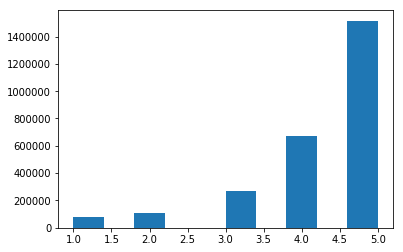

In [31]:
plt.hist(scores_books['overall'].values);

### Sentiment analysis by stars on ebooks

In [32]:
scores_books['average'].describe()

count    2.640000e+06
mean     4.704929e-01
std      3.426885e-01
min     -9.806500e-01
25%      3.435500e-01
50%      4.985000e-01
75%      7.329000e-01
max      9.914000e-01
Name: average, dtype: float64

In [33]:
scores_books['overall'].describe()

count    2.640000e+06
mean     4.302211e+00
std      1.007085e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: overall, dtype: float64

In [34]:
scores_ebooks.head()

,Unnamed: 0,overall,asin,reviewerID,sentiment_review,sentiment_summary,average
0,0,4,B000JMKNQ0,A3SZMGJMV0G16C,0.9707,0.3400,0.65535
1,1,5,B000JMKNQ0,A2EN84QHDRZLP2,0.7351,0.0000,0.36755
2,2,5,B000JMKNQ0,A1UG4Q4D3OAH3A,-0.0534,0.0000,-0.02670
3,3,4,B000JMKNQ0,AQZH7YTWQPOBE,0.9623,0.5106,0.73645
4,4,4,B000JMKNQ0,A38Z3Q6DTDIH9J,0.7870,-0.5574,0.11480


In [35]:
scores_ebooks.groupby('overall').agg('mean').drop('Unnamed: 0', axis=1)

,sentiment_review,sentiment_summary,average
overall,,,
1,-0.011494,-0.118171,-0.064833
2,0.195677,-0.029301,0.083188
3,0.511489,0.166082,0.338786
4,0.713133,0.312321,0.512727
5,0.760954,0.354309,0.557631


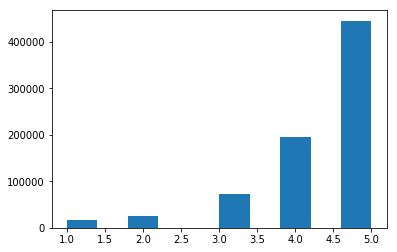

In [36]:
plt.hist(scores_ebooks['overall'].values);

In [37]:
scores_ebooks['average'].describe()

count    753709.000000
mean          0.495760
std           0.325775
min          -0.980650
25%           0.381200
50%           0.537400
75%           0.743700
max           0.991400
Name: average, dtype: float64

In [38]:
scores_ebooks['overall'].describe()

count    753709.000000
mean          4.363537
std           0.939802
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [39]:
scores_books_by_authors = pd.read_csv(scores_books_authors)
scores_ebooks_by_authors = pd.read_csv(scores_ebooks_authors)

Reviews per authors

In [40]:
scores_books_by_authors = scores_books_by_authors[['authors', 'sentiment_average_score', 'overall_score','combined_score']]
scores_ebooks_by_authors = scores_ebooks_by_authors[['authors', 'sentiment_average_score', 'overall_score','combined_score']]

scores_by_authors = scores_books_by_authors.merge(scores_ebooks_by_authors, on='authors', suffixes=('_book', '_kindle'))
scores_by_authors.head()

,authors,sentiment_average_score_book,overall_score_book,combined_score_book,sentiment_average_score_kindle,overall_score_kindle,combined_score_kindle
0,Jon Evans,0.423018,4.265808,4.055922,0.458332,4.282822,4.099743
1,Agatha Christie,0.289064,4.333456,3.955791,0.397621,4.377827,4.086535
2,James Patterson,0.294031,3.959031,3.773546,0.342400,3.333333,3.509067
3,Stella Riley,0.132290,4.600000,3.932290,0.753520,4.400000,4.453520
4,Philip K. Dick,0.269942,4.169998,3.854941,0.267467,4.229118,3.882026


In [41]:
len(scores_by_authors)

2772

In [42]:
scores_by_authors.mean()

sentiment_average_score_book      0.462495
overall_score_book                4.287626
combined_score_book               4.106308
sentiment_average_score_kindle    0.478348
overall_score_kindle              4.336031
combined_score_kindle             4.146363
dtype: float64

In [43]:
matched_booksh = matched_booksh.dropna(subset=['authors'])
matched_booksh.head()

NameError: name 'matched_booksh' is not defined

### Refined analysis on some specific authors
Now we want to see which authors has the most reviews for the books

In [44]:
books_review_per_author = matched_booksh.groupby('authors').agg('count')
most_reviewed_books_author = books_review_per_author.sort_values('overall', ascending =False)

NameError: name 'matched_booksh' is not defined

In [82]:
len(most_reviewed_books_author)

21909

In [84]:
most_reviewed_books_author.head(20)

,Unnamed: 0,overall,summary,helpful,reviewText,not_helpful
authors,,,,,,
Stephen King,24586,24586,24586,24586,24586,24586
Nora Roberts,18560,18560,18560,18560,18560,18560
James Patterson,16242,16242,16242,16242,16242,16242
Lee Child,13727,13727,13727,13727,13727,13727
H.M. Ward,13292,13292,13292,13292,13292,13292
David Baldacci,12219,12219,12219,12219,12219,12219
Michael Connelly,11683,11683,11683,11683,11683,11683
Dean Koontz,10840,10840,10840,10840,10840,10840
Abbi Glines,10696,10696,10695,10696,10696,10696


Same but for the ebooks

In [85]:
matched_ebooksh = matched_ebooksh.dropna(subset=['authors'])
matched_ebooksh.head()

,Unnamed: 0,overall,summary,helpful,reviewText,authors,not_helpful
0,128810,1,Gag Candy,3,I didnt get very far truth be told because it ...,Matthew Tomasetti,5
1,128810,1,Gag Candy,3,I didnt get very far truth be told because it ...,Brian Casimiro,5
2,128811,5,Blood Candy,1,I just finished reading blood candy and i must...,Matthew Tomasetti,1
3,128811,5,Blood Candy,1,I just finished reading blood candy and i must...,Brian Casimiro,1
4,128812,3,Vampires and Warewolfs,0,This book was okay. I have read better. There ...,Matthew Tomasetti,0


In [86]:
ebooks_review_per_author = matched_ebooksh.groupby('authors').agg('count')
most_reviewed_ebooks_author = ebooks_review_per_author.sort_values('overall', ascending =False)

In [87]:
most_reviewed_ebooks_author.head()

,Unnamed: 0,overall,summary,helpful,reviewText,not_helpful
authors,,,,,,
Nicky Charles,2631,2631,2631,2631,2631,2631
Christopher Nuttall,1823,1823,1823,1823,1823,1823
Kristen Ashley,1466,1466,1466,1466,1466,1466
Claudy Conn,1397,1397,1397,1397,1397,1397
J. S. Cooper,1361,1361,1361,1361,1361,1361


What can we see? Nothing, we don't have the same authors in the two rankings, and the number of ratings is not even of the same magnitude.

#### Taking the authors with the most reviews in books

In [88]:
merged_review_per_author = most_reviewed_books_author.merge(most_reviewed_ebooks_author,
                                                          left_index=True, right_index=True,
                                                         suffixes=('_book', '_ebook'))

In [89]:
top_books_authors = merged_review_per_author.head(20)[['overall_book','overall_ebook']]

In [90]:
match_books_top_authors = matched_booksh[matched_booksh['authors'].isin(top_books_authors.index)]
match_ebooks_top_authors = matched_ebooksh[matched_ebooksh['authors'].isin(top_books_authors.index)]

In [91]:
top_authors_weighted_books_score = 'top_authors_weighted_books_score.csv'
top_authors_weighted_kindle_score = 'top_authors_weighted_kindle_score.csv'

In [92]:
WRITE_WEIGHTED_SCORE = False

In [93]:
if WRITE_WEIGHTED_SCORE:
    compute_by_batch(match_books_top_authors.set_index('authors'), 2, top_authors_weighted_books_score, override=True)

In [94]:
if WRITE_WEIGHTED_SCORE:
    compute_by_batch(match_ebooks_top_authors.set_index('authors'), 20, top_authors_weighted_kindle_score, override=True)

In [95]:
top_authors_books_score = pd.read_csv(top_authors_weighted_books_score)
top_authors_ebooks_score = pd.read_csv(top_authors_weighted_kindle_score)

In [96]:
scores_top_authors = top_authors_books_score[['authors', 'combined_score']].merge(
    top_authors_ebooks_score[['authors', 'combined_score']], on='authors', suffixes=('_book', '_kindle'))

In [97]:
qgrid.show_grid(scores_top_authors)

QgridWidget(grid_options={'syncColumnCellResize': True, 'autoEdit': False, 'enableColumnReorder': False, 'minVisibleRows': 8, 'fullWidthRows': True, 'editable': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'forceFitColumns': True, 'explicitInitialization': True, 'enableTextSelectionOnCells': True, 'maxVisibleRows': 15}, precision=5)

In [98]:
st = pd.melt(scores_top_authors.sort_values('combined_score_book', ascending=False), id_vars='authors', value_vars=['combined_score_book', 'combined_score_kindle'])

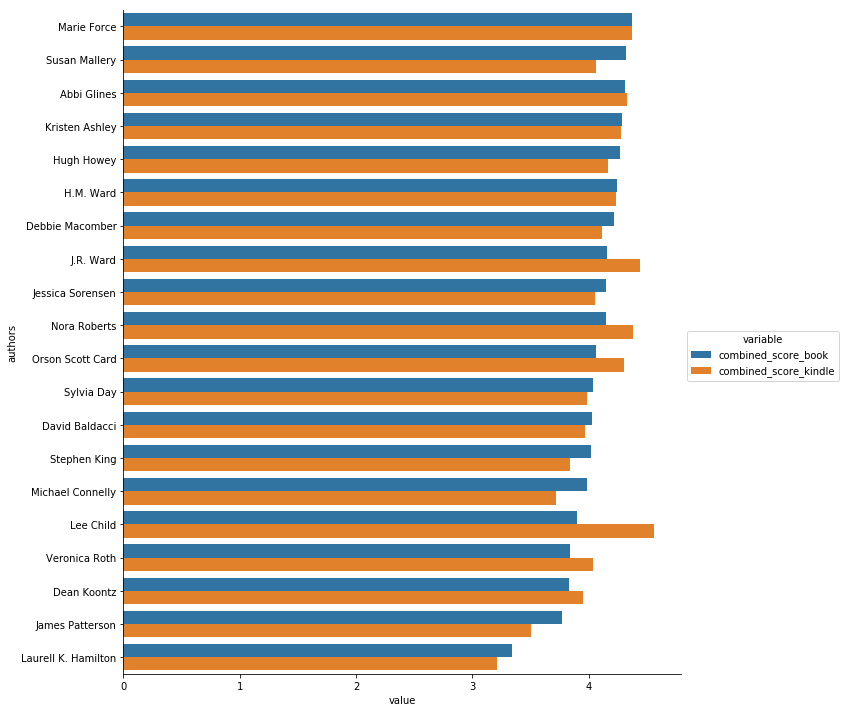

In [99]:
sns.factorplot(x = 'value', y='authors', hue='variable', data=st,kind='bar', size=10)

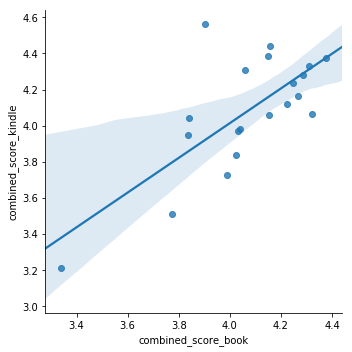

In [100]:
sns.lmplot(x='combined_score_book', y='combined_score_kindle', data=scores_top_authors)

214593

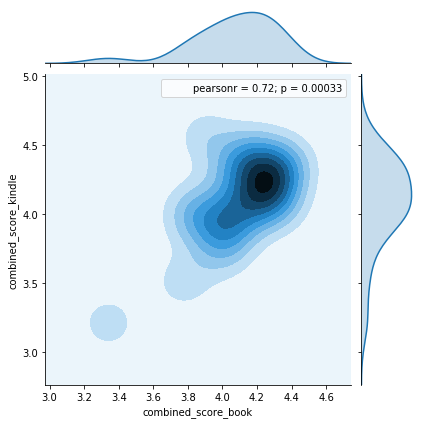

In [129]:
sns.jointplot(x='combined_score_book', y='combined_score_kindle', data=scores_top_authors, kind='kde')

#### Taking the authors with the most reviews on kindle

In [45]:
merged_review_per_author = most_reviewed_ebooks_author.merge(most_reviewed_books_author,
                                                          left_index=True, right_index=True,
                                                         suffixes=('_ebook', '_book'))

NameError: name 'most_reviewed_ebooks_author' is not defined

In [102]:
top_ebooks_authors = merged_review_per_author.head(20)[['overall_book','overall_ebook']]
match_books_top_authors = matched_booksh[matched_booksh['authors'].isin(top_ebooks_authors.index)]
match_ebooks_top_authors = matched_ebooksh[matched_ebooksh['authors'].isin(top_ebooks_authors.index)]

In [103]:
top_kauthors_weighted_books_score = 'top_kauthors_weighted_books_score.csv'
top_kauthors_weighted_kindle_score = 'top_kauthors_weighted_kindle_score.csv'

In [104]:
if WRITE_WEIGHTED_SCORE:
    compute_by_batch(match_books_top_authors.set_index('authors'), 2, top_kauthors_weighted_books_score, override=True)
    compute_by_batch(match_ebooks_top_authors.set_index('authors'), 20, top_kauthors_weighted_kindle_score, override=True)

In [105]:
top_kauthors_books_score = pd.read_csv(top_kauthors_weighted_books_score)
top_kauthors_ebooks_score = pd.read_csv(top_kauthors_weighted_kindle_score)

In [106]:
scores_top_kauthors = top_kauthors_ebooks_score[['authors', 'combined_score']].merge(
    top_kauthors_books_score[['authors', 'combined_score']], on='authors', suffixes=('_book', '_kindle'))

In [107]:
qgrid.show_grid(scores_top_kauthors)

QgridWidget(grid_options={'syncColumnCellResize': True, 'autoEdit': False, 'enableColumnReorder': False, 'minVisibleRows': 8, 'fullWidthRows': True, 'editable': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'forceFitColumns': True, 'explicitInitialization': True, 'enableTextSelectionOnCells': True, 'maxVisibleRows': 15}, precision=5)

In [108]:
stk = pd.melt(scores_top_kauthors.sort_values('combined_score_kindle', ascending=False), id_vars='authors', value_vars=['combined_score_book', 'combined_score_kindle'])

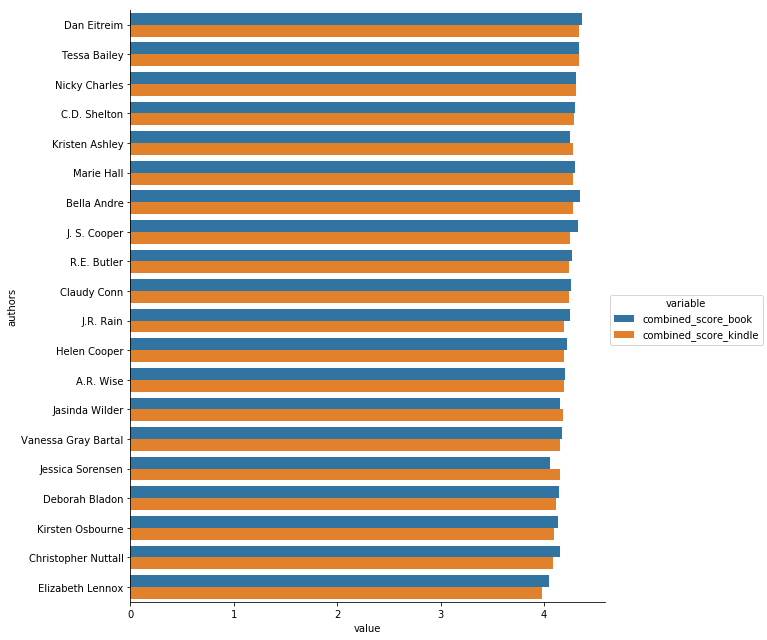

In [109]:
sns.factorplot(x = 'value', y='authors', hue='variable', data=stk, kind='bar', size=9)

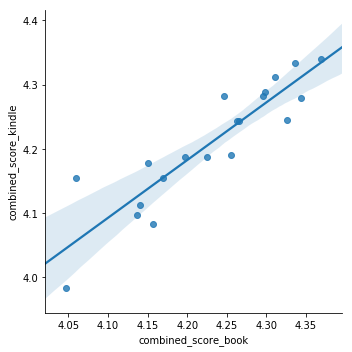

In [110]:
sns.lmplot(x='combined_score_book', y='combined_score_kindle', data=scores_top_kauthors)

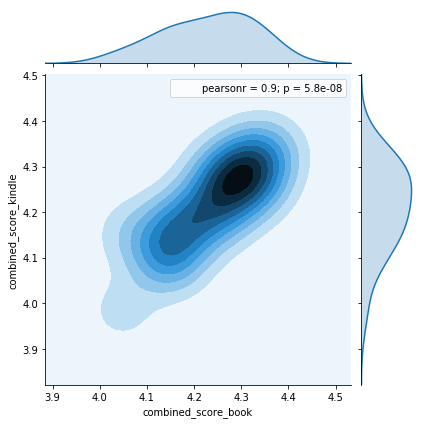

In [128]:
sns.jointplot(x='combined_score_book', y='combined_score_kindle', data=scores_top_kauthors, kind='kde')

Here it looks like the ratings are slightly better in general for the book version.

## Evolution of review through time

In [63]:
match_ebooks_author_nolax.head()

,Unnamed: 0,asin,overall,summary,reviewerID,helpful,reviewText,reviewerName,reviewTime,asin_e,authors


In [47]:
scores_books.head()

,Unnamed: 0,overall,asin,reviewerID,sentiment_review,sentiment_summary,average
0,0,5,000171287X,A3RZNH3OPW1XMB,0.8074,0.6249,0.71615
1,1,3,000171287X,AZGXZ2UUK6X,0.8834,0.0000,0.44170
2,2,5,000171287X,A2K28JHMIY3XKZ,0.7717,0.0000,0.38585
3,3,5,000171287X,A1Z54EM24Y40LL,0.9763,-0.1186,0.42885
4,4,5,000171287X,A179R0UL62Q36Z,0.9019,0.0000,0.45095


In [48]:
books_review_with_time = match_books_author_nolax.merge(scores_books, on=['reviewerID','asin'])
ebooks_review_with_time = match_ebooks_author_nolax.merge(scores_ebooks, on=['reviewerID','asin'])

#rescale the sentiment score to fit the interval [1, 5]
books_review_with_time['rescaled_sentiment'] = books_review_with_time['average'].apply(lambda x: (x+1)*2+1)
ebooks_review_with_time['rescaled_sentiment'] = ebooks_review_with_time['average'].apply(lambda x: (x+1)*2+1)

books_review_with_time.drop('overall_y', axis=1, inplace=True)
ebooks_review_with_time.drop('overall_y', axis=1, inplace=True)

books_review_with_time.rename(columns={'overall_x': 'stars'}, inplace=True)
ebooks_review_with_time.rename(columns={'overall_x': 'stars'}, inplace=True)

books_review_by_year = books_review_with_time.groupby(books_review_with_time.reviewTime.dt.year).agg(['mean', 'count'])
ebooks_review_by_year = ebooks_review_with_time.groupby(ebooks_review_with_time.reviewTime.dt.year).agg(['mean', 'count'])

In [49]:
print(len(books_review_with_time))
print(len(ebooks_review_with_time))

1299369
0


In [332]:
books_review_by_year

Unnamed: 0_x             stars          Unnamed: 0_y          \
                    mean   count      mean   count          mean   count   
reviewTime                                                                 
1997        3.696080e+06      29  4.448276      29   6302.137931      29   
1998        3.677502e+06     119  4.193277     119   6938.831933     119   
1999        3.605612e+06     377  4.143236     377   9630.498674     377   
2000        3.620084e+06    1836  4.178649    1836   9530.533224    1836   
2001        3.604125e+06    2158  4.200649    2158  10120.193234    2158   
2002        3.697621e+06    2529  4.164887    2529   8804.830763    2529   
2003        3.719432e+06    3076  4.084200    3076   8555.774707    3076   
2004        3.780666e+06    3706  4.077172    3706   8210.429574    3706   
2005        3.888561e+06    5093  4.006676    5093   8485.873945    5093   
2006        3.951545e+06    6746  4.027424    6746   8845.324637    6746   
2007        4.027024e+06    7993  4.108345    7993   9102.473915    7993   
2008        4.166195e+06   10058  4.095745   10058   9917.237920   10058   
2009        4.243892e+06   12922  4.080328   12922   9998.673812   12922   
2010        4.357839e+06   17960  4.089031   17960  10171.273719   17960   
2011        4.673877e+06   31284  4.161424   31284   9972.608234   31284   
2012        6.633594e+06  166699  4.293241  166699   9948.117997  166699   
2013        7.174907e+06  597651  4.311548  597651  10007.181318  597651   
2014        7.546593e+06  429133  4.329506  429133  10010.536298  429133   

           sentiment_review         sentiment_summary           average  \
                       mean   count              mean   count      mean   
reviewTime                                                                
1997               0.655055      29          0.411328      29  0.533191   
1998               0.631199     119          0.300351     119  0.465775   
1999               0.596562     377          0.259931     377  0.428246   
2000               0.593391    1836          0.228349    1836  0.410870   
2001               0.562849    2158          0.233990    2158  0.398419   
2002               0.617043    2529          0.237341    2529  0.427192   
2003               0.564855    3076          0.211947    3076  0.388401   
2004               0.568091    3706          0.209249    3706  0.388670   
2005               0.553500    5093          0.210878    5093  0.382189   
2006               0.554136    6746          0.209585    6746  0.381860   
2007               0.571526    7993          0.220370    7993  0.395948   
2008               0.591885   10058          0.221211   10058  0.406548   
2009               0.599527   12922          0.231333   12922  0.415430   
2010               0.627689   17960          0.237632   17960  0.432660   
2011               0.663259   31284          0.259942   31284  0.461600   
2012               0.686474  166699          0.285477  166699  0.485976   
2013               0.664729  597651          0.296570  597651  0.480649   
2014               0.656172  429133          0.300866  429133  0.478519   

                   rescaled_sentiment          
             count               mean   count  
reviewTime                                     
1997            29           4.066383      29  
1998           119           3.931550     119  
1999           377           3.856493     377  
2000          1836           3.821740    1836  
2001          2158           3.796839    2158  
2002          2529           3.854384    2529  
2003          3076           3.776802    3076  
2004          3706           3.777340    3706  
2005          5093           3.764378    5093  
2006          6746           3.763721    6746  
2007          7993           3.791896    7993  
2008         10058           3.813095   10058  
2009         12922           3.830860   12922  
2010         17960           3.865321   17960  
2011         31284     

In [143]:
ebooks_review_by_year

Unnamed: 0_x         overall_x         Unnamed: 0_y          \
                     mean   count      mean   count         mean   count   
reviewTime                                                                 
2000        240300.285714       7  4.714286       7  5639.428571       7   
2001         70822.500000       2  5.000000       2  2455.500000       2   
2002           755.000000       1  5.000000       1  1229.000000       1   
2003        793935.500000       2  5.000000       2  5381.500000       2   
2004        246122.125000       8  4.375000       8  4320.750000       8   
2005        330697.380952      21  4.666667      21  3941.380952      21   
2006        314262.812500      16  4.437500      16  4298.750000      16   
2007        263150.142857      21  4.428571      21  4122.380952      21   
2008        214243.472222      36  4.500000      36  7240.472222      36   
2009         27024.541935     155  4.148387     155  5468.496774     155   
2010         26806.483452    1541  4.378975    1541  7736.800779    1541   
2011         74620.710073   15021  4.242061   15021  7277.448838   15021   
2012        211134.512104   94227  4.314464   94227  5407.420028   94227   
2013        421840.439229  347395  4.327403  347395  4493.026860  347395   
2014        667114.616360  313135  4.401290  313135  3891.763377  313135   

           overall_y         sentiment_review         sentiment_summary  \
                mean   count             mean   count              mean   
reviewTime                                                                
2000        4.714286       7         0.710943       7          0.632729   
2001        5.000000       2        -0.037500       2          0.246950   
2002        5.000000       1         0.926100       1          0.718400   
2003        5.000000       2         0.016000       2          0.278700   
2004        4.375000       8         0.804375       8          0.234038   
2005        4.666667      21         0.704381      21          0.223538   
2006        4.437500      16         0.348287      16          0.461738   
2007        4.428571      21         0.626981      21          0.117433   
2008        4.500000      36         0.772014      36          0.118592   
2009        4.148387     155         0.644612     155          0.256054   
2010        4.378975    1541         0.721034    1541          0.290294   
2011        4.242061   15021         0.681244   15021          0.282986   
2012        4.314464   94227         0.699572   94227          0.292185   
2013        4.327403  347395         0.684401  347395          0.298584   
2014        4.401290  313135         0.688693  313135          0.308708   

                     average          
             count      mean   count  
reviewTime                            
2000             7  0.671836       7  
2001             2  0.104725       2  
2002             1  0.822250       1  
2003             2  0.147350       2  
2004             8  0.519206       8  
2005            21  0.463960      21  
2006            16  0.405012      16  
2007            21  0.372207      21  
2008            36  0.445303      36  
2009           155  0.450333     155  
2010          1541  0.505664    1541  
2011         15021  0.482115   15021  
2012         94227  0.495878   94227  
2013        347395  0.491492  347395  
2014        313135  0.498701  313135

In [ ]:
books_review_timeline_month_mean = books_review_with_time.groupby([
    books_review_with_time.index,
    books_review_with_time.reviewTime.dt.month]).agg(['mean'])

books_review_timeline_month_cnt= books_review_with_time.groupby([
    books_review_with_time.index,
    books_review_with_time.reviewTime.dt.month]).agg(['count'])

#### Evolution of book reviews

In [ ]:
books_review_timeline_month_mean[['stars', 'rescaled_sentiment']].plot(figsize=(25,10),title='Evolution of ratings with time');

KeyboardInterrupt: 

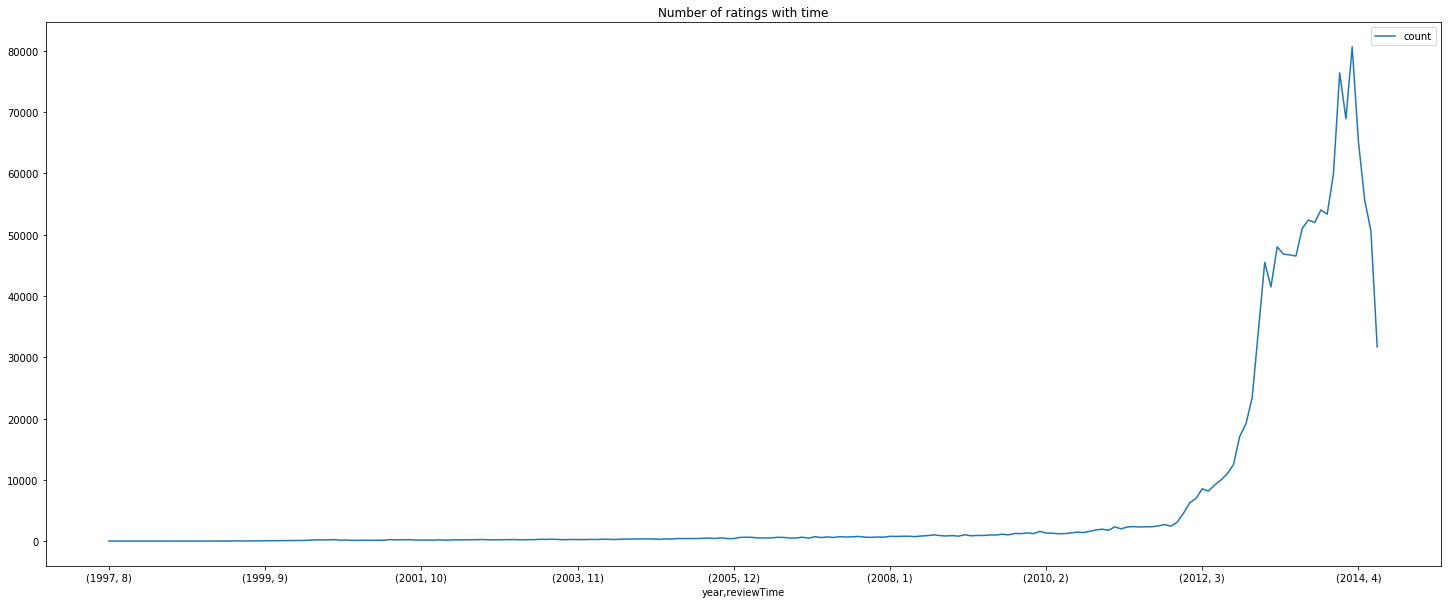

In [326]:
books_review_timeline_month_cnt['stars'].plot(figsize=(25,10),title='Number of ratings with time')

#### Evolution of kindle reviews

In [328]:
ebooks_review_timeline_month_mean = ebooks_review_with_time.groupby([
    ebooks_review_with_time.reviewTime.dt.year,
    ebooks_review_with_time.reviewTime.dt.month]).agg(['mean'])

ebooks_review_timeline_month_cnt = ebooks_review_with_time.groupby([
    ebooks_review_with_time.reviewTime.dt.year,
    ebooks_review_with_time.reviewTime.dt.month]).agg(['count'])

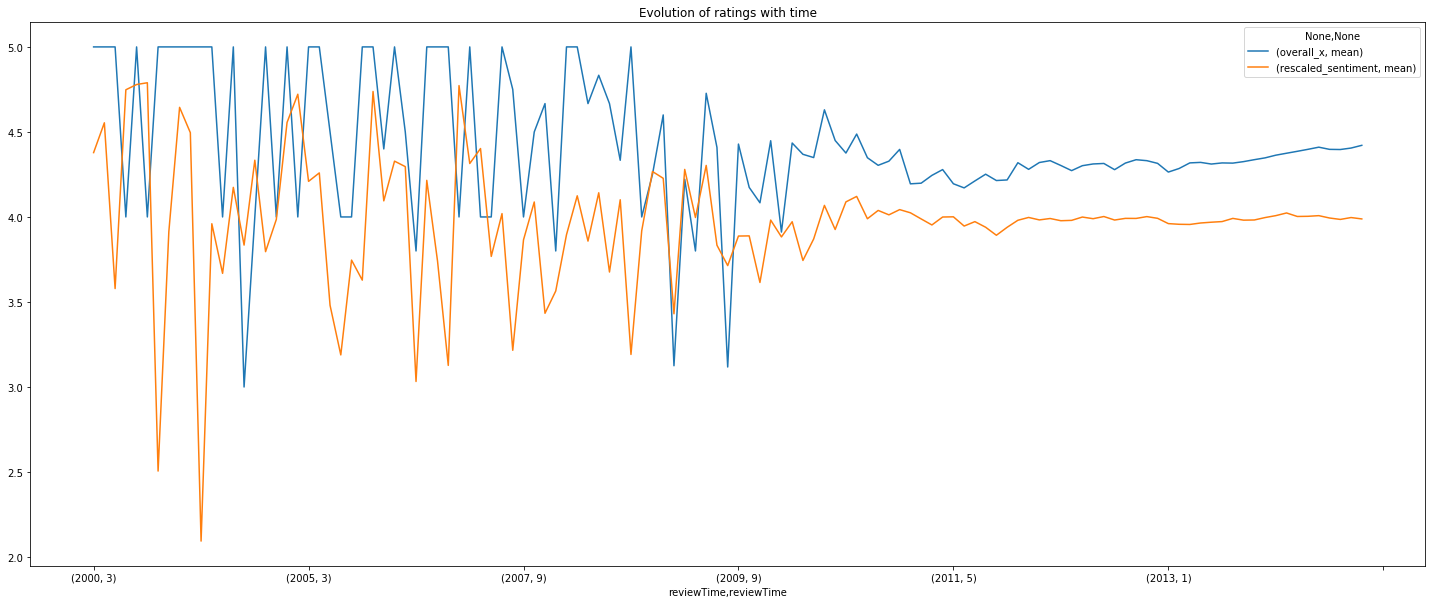

In [329]:
ebooks_review_timeline_month_mean[['overall_x', 'rescaled_sentiment']].plot(figsize=(25,10), title='Evolution of ratings with time')

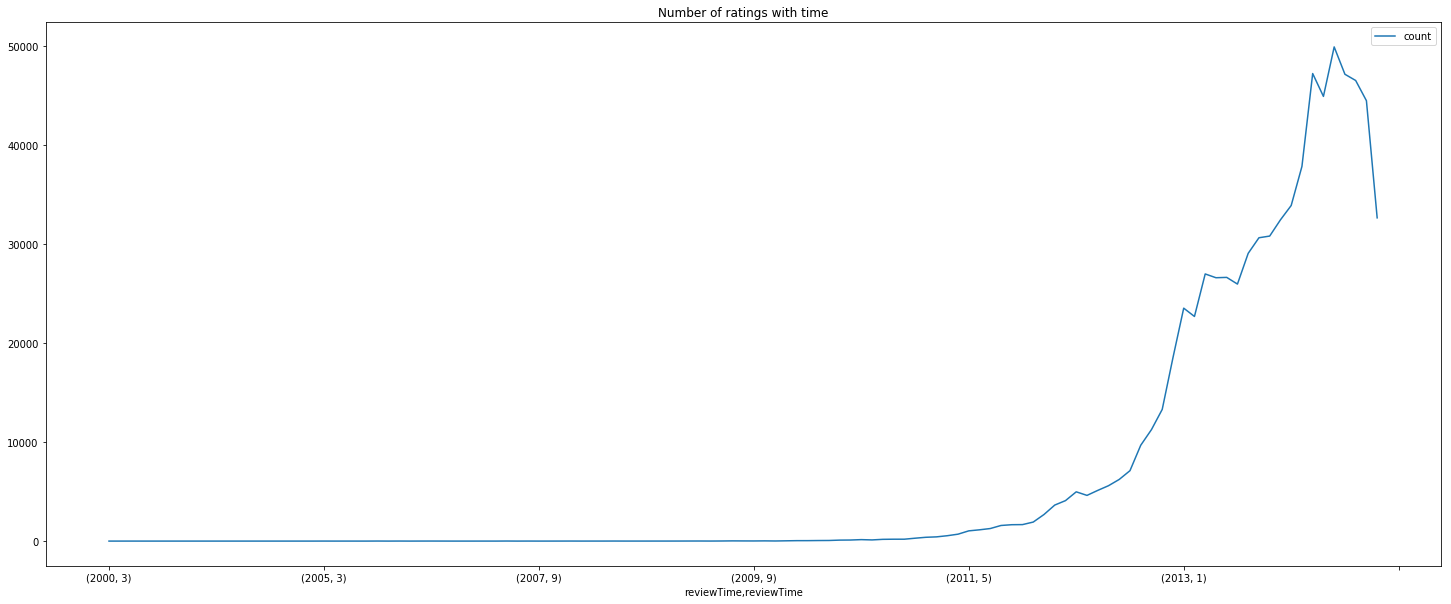

In [330]:
ebooks_review_timeline_month_cnt['overall_x'].plot(figsize=(25,10),  title='Number of ratings with time')

### old

def compute_review_spark(data):
    func = udf(lambda x: sid.polarity_scores(x)['compound'], T.DoubleType())
    
    data = data.withColumn('sentiment_review', func('reviewText'))
    data = data.withColumn('sentiment_summary', func('summary'))
    data = data.withColumn('average', average('sentiment_review', 'sentiment_summary'))
    
    output = data.groupby('overall').mean()
    return output

reviews_books_with_sentiment[reviews_books_with_sentiment['overall'] == 1].head()

reviews_books_with_sentiment.iloc[212]['reviewText']

This review above has a really positive sentiment score of 0.9735, but if we read the review, we can understand that it is quite the opposite. A second example is "Not so good" which yields a score of 0.4927, showing us the limitation of Vader.

We can observe here that the better the rating is, the more positive the text of the review is in average. The reviews with a rating of 1 are not negative in average. Even if the scores are not always accurate due to the limitation of Vader, they are consistent in average with the ratings.

reviews_ebooks_with_sentiment = matched_ebooks.copy()
reviews_ebooks_with_sentiment['sentiment_review'] = matched_ebooks['reviewText'].apply(f_sentiment)
reviews_ebooks_with_sentiment['sentiment_summary'] = matched_ebooks['summary'].apply(f_sentiment)
reviews_ebooks_with_sentiment['average'] = (reviews_ebooks_with_sentiment['sentiment_review'] + reviews_ebooks_with_sentiment['sentiment_summary'])*0.5

The ratings seem to be consistent with the sentiment's score here again. Compared to books, the sentiment's score is slightly lower and even negative for a rating of 1.

For the same rating, the books reviewer seems to be more positive in their review, this may be explained by the fact that books reviews tend to be longer and more descriptive than ebooks reviews.

This analysis may not be really representative of the reality due to the limitation in size of our final dataset.

Sources:
* *Improving the Amazon Review System by Exploiting the Credibility and Time-Decay of Public Reviews*, Bo-Chun Wang, Wen-Yuan Zhu, and Ling-Jyh Chen
* Hutto, C.J. & Gilbert, E.E. (2014). *VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14)*. Ann Arbor, MI, June 2014.

In [150]:
sc.stop()